In [306]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point
from shapely.geometry import LineString
from shapely.geometry import MultiLineString
from collections import deque
import datetime
from datetime import timedelta

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

CRS_PLOT = 'EPSG:4326'
DATA_DIR = '../data'
EXPORTS_DIR = f'{DATA_DIR}/exports'

In [2]:
b25_times_df = pd.read_csv(f'{EXPORTS_DIR}/b25_weekday_stop_times.csv')
b25_trajectories_df = pd.read_csv(f'{EXPORTS_DIR}/b25_all_trajectories.csv')
b25_trajectories_gdf = gpd.GeoDataFrame(b25_trajectories_df, geometry=gpd.points_from_xy(b25_trajectories_df['longitude'], b25_trajectories_df['latitude']), crs=CRS_PLOT)

In [3]:
bus_ids = set(b25_trajectories_gdf['bus_id'])

In [4]:
# Collect continuous trajectories into ID-grouped dictionary.
b25_trajectories_dict = {}
for bus_id in bus_ids:
    df = b25_trajectories_gdf[b25_trajectories_gdf['bus_id'] == bus_id]
    direction = df.iloc[0]['x']

    trajectories = []
    trajectory = []

    for i in range(0, len(df)):
        row = df.iloc[i]
        if row['x'] != direction:
            if direction == 0:
                trajectories.append(trajectory)
            trajectory = []
            direction = row['x']

        (x, y, t) = row[['longitude', 'latitude', 'datetime']]
        trajectory.append((x, y, t))
    if direction == 0:
        trajectories.append(trajectory)
    b25_trajectories_dict[bus_id] = trajectories

In [5]:
bk = ox.io.load_graphml('bk.graphml')
route_graph = ox.io.load_graphml('b25.graphml')

route_gdf = gpd.read_file(f'{EXPORTS_DIR}/b25_220.shp').iloc[1:]
route_graph_edges = ox.nearest_edges(bk, route_gdf['stop_lon'], route_gdf['stop_lat'])
route_graph_edge_nodes = [[e[0], e[1]] for e in route_graph_edges]

In [6]:
def dedup_consecutive(a):
    b = []
    last = None
    for i in range(0, len(a)):
        c = a[i]
        if c != last:
            last = c
            b.append(c)
    return b

In [7]:
route_graph_nodes = []
for i in range(0, len(route_graph_edge_nodes) - 1):
    edge0 = route_graph_edge_nodes[i]
    edge1 = route_graph_edge_nodes[i + 1]
    sp = ox.shortest_path(bk, edge0[1], edge1[0])
    if sp is None:
        raise Exception('oof')
    nd = dedup_consecutive(edge0 + sp + [edge1[0]])
    route_graph_nodes += nd

route_graph_nodes = dedup_consecutive(route_graph_nodes)

In [8]:
def snap_to_edge(point, edge):
    p1 = edge[0]
    p2 = edge[1]
    x1 = float(p1[0])
    y1 = float(p1[1])
    x2 = float(p2[0])
    y2 = float(p2[1])
    x3 = point[0]
    y3 = point[1]
    
    m1 = (y2 - y1) / (x2 - x1)
    m3 = -1.0 / m1
    x = (m1 * x1 - m3 * x3 - y1 + y3) / (m1 - m3)
    y = m1 * (x - x1) + y1
    return [x, y]

In [150]:
class RouteNode:
    def __init__(self, i=0, id=0, node=None):
        self.i = i
        self.id = id
        self.node = node
        self.next_node = None
        self.x = node['x']
        self.y = node['y']
        self.t = 0
        self.st = 0
        
    def set_next_node(self, next_node):
        self.next_node = next_node
        self.distance_to_next =ox.distance.euclidean_dist_vec(self.y, self.x, next_node.y, next_node.x)

class Stop:
    def __init__(self, id=0, x=0, y=0, t=0):
        self.id = id
        self.x = x
        self.y = y
        self.t = t
        self.st = 0
        
        self.edge = ox.nearest_edges(route_graph, [self.x], [self.y])[0]
        
        self.prev_node_id = self.edge[0]
        self.next_node_id = self.edge[1]
        self.prev_node_index = route_graph_nodes.index(self.prev_node_id)
        try:
            self.next_node_index = route_graph_nodes.index(self.next_node_id, self.prev_node_index)
        except ValueError:
            self.next_node_index = route_graph_nodes.index(self.next_node_id)
        
        self.prev_node = route_graph.nodes[self.prev_node_id]
        self.next_node = route_graph.nodes[self.next_node_id]
        
        route_point = snap_to_edge([x, y], [[self.prev_node['x'], self.prev_node['y']], [self.next_node['x'], self.next_node['y']]])
        self.rx = route_point[0]
        self.ry = route_point[1]
        
        self.prev_node_dist = ox.distance.euclidean_dist_vec(self.ry, self.rx, self.prev_node['y'], self.prev_node['x'])
        self.next_node_dist = ox.distance.euclidean_dist_vec(self.ry, self.rx, self.next_node['y'], self.next_node['x'])
        
    def get_nearest_edge(self):
        edge = ox.nearest_edges(route_graph, route_gdf['stop_lon'], route_gdf['stop_lat'])
        
class TrajectoryPoint(Stop):
    def __init__(self, i=0, x=0, y=0, t=0):
        super().__init__(i, x, y, t)
        
        next_node_t = route_nodes[self.next_node_index].t
        prev_node_t = route_nodes[self.prev_node_index].t
        
        if next_node_t == 0:
            self.t_expected = None
        elif prev_node_t == 0:
            self.t_expected = None
        else:
            next_node_t -= datetime.timedelta(days=51)
            prev_node_t -= datetime.timedelta(days=51)
            self.t_expected = (self.prev_node_dist / (self.prev_node_dist + self.next_node_dist)) * (next_node_t - prev_node_t) + prev_node_t

In [10]:
route_nodes = []

for i in range(0, len(route_graph_nodes)):
    id = route_graph_nodes[i]
    route_nodes.append(RouteNode(i, id, route_graph.nodes[id]))
    
for i in range(0, len(route_graph_nodes) - 1):
    route_nodes[i].set_next_node(route_nodes[i + 1])

In [226]:
stops = []
stop_dict = {}
for i in range(0, len(route_gdf)):
    row = route_gdf.iloc[i]
    stop = Stop(id=int(row['stop_id']), x=row['stop_lon'], y=row['stop_lat'], t=row['departure_'])
    stops.append(stop)
    stop_dict[stop.id] = stop

In [12]:
trajectory_df = pd.read_csv(f'{EXPORTS_DIR}/b25_4845.csv')
trajectory_gdf = gpd.GeoDataFrame(trajectory_df, geometry=gpd.points_from_xy(trajectory_df['longitude'], trajectory_df['latitude']), crs=CRS_PLOT)
trajectory_gdf['datetime'] = pd.to_datetime(trajectory_gdf['datetime'])
trajectory_gdf

trajectory_points = []
for i in range(0, len(trajectory_gdf)):
    row = trajectory_gdf.iloc[i]
    trajectory_points.append(TrajectoryPoint(i=0, x=row['longitude'], y=row['latitude'], t=row['datetime']))

In [13]:
trajectory_df.head()

,route,x,latitude,longitude,bus_id,datetime,geometry
0,MTA NYCT_B25,0,40.702576,-73.991409,MTA NYCT_4845,2021-06-03 13:03:13,POINT (-73.99141 40.70258)
1,MTA NYCT_B25,0,40.702648,-73.990692,MTA NYCT_4845,2021-06-03 13:05:28,POINT (-73.99069 40.70265)
2,MTA NYCT_B25,0,40.703316,-73.992607,MTA NYCT_4845,2021-06-03 13:06:59,POINT (-73.99261 40.70332)
3,MTA NYCT_B25,0,40.702412,-73.993271,MTA NYCT_4845,2021-06-03 13:09:50,POINT (-73.99327 40.70241)
4,MTA NYCT_B25,0,40.698799,-73.991425,MTA NYCT_4845,2021-06-03 13:11:53,POINT (-73.99142 40.69880)


In [14]:
trajectory_points = [TrajectoryPoint(i=0, x=x, y=y, t=datetime.datetime.strptime(t, '%Y-%m-%d %H:%M:%S')) for (x, y, t) in b25_trajectories_dict['MTA NYCT_4830'][0]]

In [292]:
def calculate_route_node_expected_times(stops):
    for route_node in route_nodes:
        route_node.t = 0
        
    for k in range(0, len(stops) - 1):
        stop = stops[k] 
        stop.next_node_index
        next_stop = stops[k + 1]
        next_stop.prev_node_index

        total_dist = stop.next_node_dist
        for i in range(stop.next_node_index, next_stop.prev_node_index + 1):
            total_dist += route_nodes[i].distance_to_next
        total_dist += next_stop.prev_node_dist
        t0 = stop.t
        t1 = next_stop.t

        for i in range(stop.next_node_index, next_stop.prev_node_index + 1):
            node_dist = 0
            for j in range(i, next_stop.prev_node_index + 1):
                node_dist += route_nodes[j].distance_to_next
            node_dist += next_stop.prev_node_dist

            ratio = (total_dist - node_dist) / total_dist
            route_nodes[i].t = (t1 - t0) * ratio + t0

In [281]:
def calculate_route_node_actual_times(trajectory_points):
    # Calculate the actual time at each route node based on the trajectory times.
    for route_node in route_nodes:
        route_node.st = 0
        
    for k in range(0, len(trajectory_points) - 1):
        trajectory_point = trajectory_points[k] 
        trajectory_point.next_node_index
        next_trajectory_point = trajectory_points[k + 1]
        next_trajectory_point.prev_node_index

        total_dist = trajectory_point.next_node_dist
        for i in range(trajectory_point.next_node_index, next_trajectory_point.prev_node_index + 1):
            total_dist += route_nodes[i].distance_to_next
        total_dist += next_trajectory_point.prev_node_dist
        t0 = trajectory_point.t
        t1 = next_trajectory_point.t

        for i in range(trajectory_point.next_node_index, next_trajectory_point.prev_node_index + 1):
            node_dist = 0
            for j in range(i, next_trajectory_point.prev_node_index + 1):
                node_dist += route_nodes[j].distance_to_next
            node_dist += next_trajectory_point.prev_node_dist

            ratio = (total_dist - node_dist) / total_dist
            route_nodes[i].st = (t1 - t0) * ratio + t0

In [16]:
def calculate_stop_actual_times(trajectory_points):
    # Calculate the actual time at each stop based on the trajectory times.
    for stop in stops:
        stop.st = 0
    for k in range(0, len(stops) - 1):
        stop = stops[k]
        stop_prev_node = route_nodes[stop.prev_node_index]
        stop_next_node = route_nodes[stop.next_node_index]
        if stop_prev_node.st != 0 and stop_next_node.st != 0:
            ratio = stop.prev_node_dist / (stop.prev_node_dist + stop.next_node_dist)
            t0 = stop_prev_node.st
            t1 = stop_next_node.st
            stop.st = (t1 - t0) * ratio + t0

In [17]:
def plot(trajectory_points):
    fig, ax = plt.subplots(figsize=(40, 30))
    ox.plot_graph(route_graph, ax=ax, bgcolor=None, node_size=10, node_color='black', bbox=(40.70501, 40.67289, -73.89407, -74.00660), show=False, close=False)

    X = [route_graph.nodes[n]['x'] for n in route_graph_nodes]
    Y = [route_graph.nodes[n]['y'] for n in route_graph_nodes]
    ax.scatter(X, Y, color='black')

    X = [t.rx for t in stops]
    Y = [t.ry for t in stops]
    ax.scatter(X, Y, color='red')

    for i in range(0, len(stops)):
        x = X[i]
        y = Y[i]
        k = 1 if i % 2 == 0 else -4
        stop = stops[i]
        if stop.st != None and stop.st != 0:
            ax.annotate(stop.st.strftime('%H:%M'), (x, y),
                       xytext=(0, 20 * k), textcoords='offset pixels', rotation=45, ha='center', color='red')

    X = [t.rx for t in trajectory_points]
    Y = [t.ry for t in trajectory_points]
    ax.scatter(X, Y, color='blue')

    for i in range(0, len(trajectory_points)):
        x = X[i]
        y = Y[i]
        k = 1 if i % 2 == 0 else -4
        tp = trajectory_points[i]
        if tp.t != 0:
            ax.annotate(tp.t.strftime('%H:%M'), (x, y),
                       xytext=(0, 20 * k), textcoords='offset pixels', rotation=45, ha='center', color='blue')

    plt.show()

In [18]:
stop_times_df = pd.read_csv(f'{EXPORTS_DIR}/b25_weekday_stop_times.csv')
stop_times_df

,trip_id,308626,308025,302355,306437,302356,302357,302359,302358,303011,...,307253,307254,307255,307256,307257,307259,307260,307631,307263,901211
0,EN_B1-Weekday-SDon-005800_B25_201,00:58:00,00:58:55,01:00:19,01:00:49,01:01:28,01:02:13,01:02:46,01:03:30,01:04:00,...,01:27:53,01:29:11,01:30:00,01:31:13,01:32:26,01:33:42,01:34:58,01:35:57,01:38:04,01:40:00
1,EN_B1-Weekday-SDon-014400_B25_201,02:24:00,02:24:46,02:25:56,02:26:21,02:26:53,02:27:31,02:27:58,02:28:35,02:29:00,...,02:49:53,02:51:11,02:52:00,02:52:59,02:53:57,02:54:57,02:55:58,02:56:45,02:58:27,03:00:00
2,EN_B1-Weekday-SDon-021800_B25_201,03:38:00,03:38:46,03:39:56,03:40:21,03:40:53,03:41:31,03:41:58,03:42:35,03:43:00,...,04:03:53,04:05:11,04:06:00,04:06:59,04:07:57,04:08:57,04:09:58,04:10:45,04:12:27,04:14:00
3,EN_B1-Weekday-SDon-029200_B25_201,04:52:00,04:52:46,04:53:56,04:54:21,04:54:53,04:55:31,04:55:58,04:56:35,04:57:00,...,05:17:53,05:19:11,05:20:00,05:20:59,05:21:57,05:22:57,05:23:58,05:24:45,05:26:27,05:28:00
4,EN_B1-Weekday-SDon-033200_Q56_453,05:32:00,05:33:04,05:34:42,05:35:17,05:36:02,05:36:55,05:37:34,05:38:25,05:39:00,...,06:03:37,06:05:05,06:06:00,06:07:13,06:08:26,06:09:42,06:10:58,06:11:57,06:14:04,06:16:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,EN_B1-Weekday-130900_B83_317,21:49:00,21:50:23,21:52:28,21:53:14,21:54:11,21:55:19,21:56:09,21:57:15,21:58:00,...,22:32:49,22:34:46,22:36:00,22:37:21,22:38:41,22:40:04,22:41:27,22:42:32,22:44:52,22:47:00
100,EN_B1-Weekday-133200_B25_238,22:12:00,22:13:23,22:15:28,22:16:14,22:17:11,22:18:19,22:19:09,22:20:15,22:21:00,...,22:55:49,22:57:46,22:59:00,23:00:21,23:01:41,23:03:04,23:04:27,23:05:32,23:07:52,23:10:00
101,EN_B1-Weekday-135700_B25_235,22:37:00,22:38:23,22:40:28,22:41:14,22:42:11,22:43:19,22:44:09,22:45:15,22:46:00,...,23:18:05,23:19:52,23:21:00,23:22:13,23:23:26,23:24:42,23:25:58,23:26:57,23:29:04,23:31:00
102,EN_B1-Weekday-138200_B83_319,23:02:00,23:03:23,23:05:28,23:06:14,23:07:11,23:08:19,23:09:09,23:10:15,23:11:00,...,23:40:21,23:41:59,23:43:00,23:44:13,23:45:26,23:46:42,23:47:58,23:48:57,23:51:04,23:53:00


In [73]:
def find_closest_schedule():
    columns = list(route_gdf['stop_id'])
    route_actual_times = pd.DataFrame({column: [stop.st.strftime('%H:%M:%S') if stop.st != 0 else None] for (column, stop) in zip(columns, stops)}, columns=columns)
    start_col = route_actual_times.columns[1]
    actual_start_time = pd.to_datetime(route_actual_times[start_col].iloc[0])
    if actual_start_time == None:
        return None
    
    end_col = route_actual_times.columns[-3]
    actual_end_time = pd.to_datetime(route_actual_times[end_col].iloc[0])
    if actual_end_time == None:
        return None
    
    stop_diffs_df = stop_times_df.copy()[['trip_id', str(start_col)]]
    stop_diffs_df[str(start_col)] = pd.to_datetime(stop_diffs_df[str(start_col)])
    stop_diffs_df['diff'] = stop_diffs_df[str(start_col)] - actual_start_time
    threshold = 5
    matching_df = stop_diffs_df[(stop_diffs_df['diff'] < timedelta(minutes=threshold)) & (stop_diffs_df['diff'] > timedelta(minutes=-threshold))]
    matching_trips = list(matching_df['trip_id'])
    matching_df

    df_a = stop_times_df[stop_times_df['trip_id'].isin(matching_trips[0:1])]
    df_b = route_actual_times
    df_a.columns = [str(c) for c in df_a.columns]
    df_b.columns = [str(c) for c in df_b.columns]
    return pd.concat([df_a, df_b])

In [111]:
def dt_string_to_seconds(dt_string):
    if dt_string is None:
        return np.nan
    hours = int(dt_string[0:2])
    minutes = int(dt_string[3:5])
    seconds = int(dt_string[6:8])
    return hours * 24 * 60 + minutes * 60 + seconds

def calculate_time_diff(matched_df):
    return matched_df.iloc[:, 3:-3].applymap(dt_string_to_seconds).diff(1).iloc[1, :]

In [293]:
diff_rows = []

for bus_id, trajectories in b25_trajectories_dict.items():
    for trajectory in trajectories:
        if len(trajectory) < 10:
            continue
        trajectory_points = [TrajectoryPoint(i=0, x=x, y=y, t=datetime.datetime.strptime(t, '%Y-%m-%d %H:%M:%S')) for (x, y, t) in trajectory]
        calculate_route_node_actual_times(trajectory_points)
        calculate_stop_actual_times(trajectory_points)
        matched_df = find_closest_schedule()
        if matched_df is not None:
            display(matched_df)
            
            expected_stops = []
            for i in range(3, len(matched_df.columns) - 3):
                matching_stop = stop_dict[int(matched_df.columns[i])]
                x = matching_stop.x
                y = matching_stop.y
                t = pd.to_datetime(matched_df.iloc[0, i])
                expected_stop = Stop(id=matching_stop.id, x=x, y=y, t=t)
                expected_stops.append(expected_stop)
                
            calculate_route_node_expected_times(expected_stops)
            
            #df = pd.DataFrame.from_dict({n.id: n.t for n in route_nodes}, orient='index')
            df_dict = {n.id: n.t for n in route_nodes if n.t != 0 and n.st != 0}
            expected_df = pd.DataFrame([df_dict], columns=df_dict.keys())
            df_dict = {n.id: n.st for n in route_nodes if n.t != 0 and n.st != 0}
            actual_df = pd.DataFrame([df_dict], columns=df_dict.keys())
            
            expected_df = expected_df.applymap(lambda x: x.strftime('%H:%M:%S'))
            actual_df = actual_df.applymap(lambda x: x.strftime('%H:%M:%S'))
            diff_df = calculate_time_diff(pd.concat([expected_df, actual_df]))
            diff_rows.append(diff_df)
            break

diff_df = pd.DataFrame(diff_rows)
display(diff_df)

,trip_id,308626,308025,302355,306437,302356,302357,302359,302358,303011,...,307253,307254,307255,307256,307257,307259,307260,307631,307263,901211
47,EN_B1-Weekday-080500_B25_215,13:25:00,13:26:13,13:28:05,13:28:46,13:29:37,13:30:37,13:31:21,13:32:20,13:33:00,...,14:18:02,14:20:28,14:22:00,14:23:35,14:25:10,14:26:48,14:28:27,14:29:44,14:32:29,14:35:00
0,NaN,NaN,None,13:29:53,13:30:28,13:31:20,13:31:53,13:32:41,13:33:26,13:34:23,...,14:17:48,14:20:23,14:21:43,14:23:04,14:24:07,14:25:25,14:26:26,14:27:38,None,None


,trip_id,308626,308025,302355,306437,302356,302357,302359,302358,303011,...,307253,307254,307255,307256,307257,307259,307260,307631,307263,901211
44,EN_B1-Weekday-SDon-078200_Q24_410,13:02:00,13:03:13,13:05:05,13:05:46,13:06:37,13:07:37,13:08:21,13:09:20,13:10:00,...,13:55:02,13:57:28,13:59:00,14:00:35,14:02:10,14:03:48,14:05:27,14:06:44,14:09:29,14:12:00
0,NaN,NaN,None,13:08:43,13:09:55,13:10:29,13:11:00,13:12:03,13:12:39,13:13:23,...,13:55:17,13:57:26,13:59:03,14:00:19,14:01:15,14:02:44,14:04:06,14:06:57,None,None


,trip_id,308626,308025,302355,306437,302356,302357,302359,302358,303011,...,307253,307254,307255,307256,307257,307259,307260,307631,307263,901211
45,EN_B1-Weekday-079000_B25_223,13:10:00,13:11:13,13:13:05,13:13:46,13:14:37,13:15:37,13:16:21,13:17:20,13:18:00,...,14:03:02,14:05:28,14:07:00,14:08:35,14:10:10,14:11:48,14:13:27,14:14:44,14:17:29,14:20:00
0,NaN,NaN,None,13:14:44,13:15:46,13:16:14,13:16:39,13:17:15,13:17:50,13:18:36,...,13:57:10,13:59:29,14:01:26,14:02:26,14:03:08,14:03:52,14:05:21,14:06:21,None,None


,3174844140,465132522,7014570048,42519202,5649546987,2842884234,6224369594,219785432,2100701384,1767282046,...,8904004315,6882221847,42465036,42465040,5488505763,5488505768,42465043,42465047,2800241803,42465054
0,103.0,103.0,115.0,103.0,101.0,93.0,79.0,80.0,81.0,81.0,...,-8.0,-9.0,-4.0,1.0,5.0,-16.0,-14.0,-13.0,-16.0,-20.0
0,252.0,249.0,244.0,231.0,229.0,221.0,205.0,206.0,207.0,206.0,...,0.0,1.0,2.0,22.0,25.0,4.0,5.0,-2.0,-7.0,-12.0
0,121.0,116.0,109.0,96.0,93.0,81.0,61.0,61.0,61.0,61.0,...,1808.0,-350.0,-347.0,-322.0,-320.0,-323.0,-335.0,-370.0,-371.0,-373.0


In [324]:
diff_avg_df = diff_df.mean()
diff_avg_df = diff_avg_df.apply(lambda x: min(x, 300))
diff_avg_df = diff_avg_df.apply(lambda x: max(x, -300))

In [325]:
def create_route_subgraph(node_ids):
    graph = nx.MultiDiGraph()
    for node_id in node_ids:
        node = bk.nodes[node_id]
        graph.add_node(node_id, **node)
    for i in range(0, len(node_ids) - 1):
        graph.add_edge(node_ids[i], node_ids[i + 1])
    graph.graph['crs'] = CRS_PLOT
    return graph

route_subgraph = create_route_subgraph([n for n in route_graph_nodes if n in set(diff_avg_df.index)])

for edge in route_subgraph.edges:
    route_subgraph.add_edge(edge[0], edge[1], edge[2], weight=0)

for i in range(0, len(route_nodes) - 1):
    route_node = route_nodes[i]
    next_node = route_nodes[i + 1]
    if route_node.id not in diff_avg_df.index:
        continue
    if next_node.id not in diff_avg_df.index:
        continue
    time_delta = diff_avg_df.loc[route_node.id]
    route_subgraph.add_edge(route_node.id, next_node.id, 0, weight=time_delta)

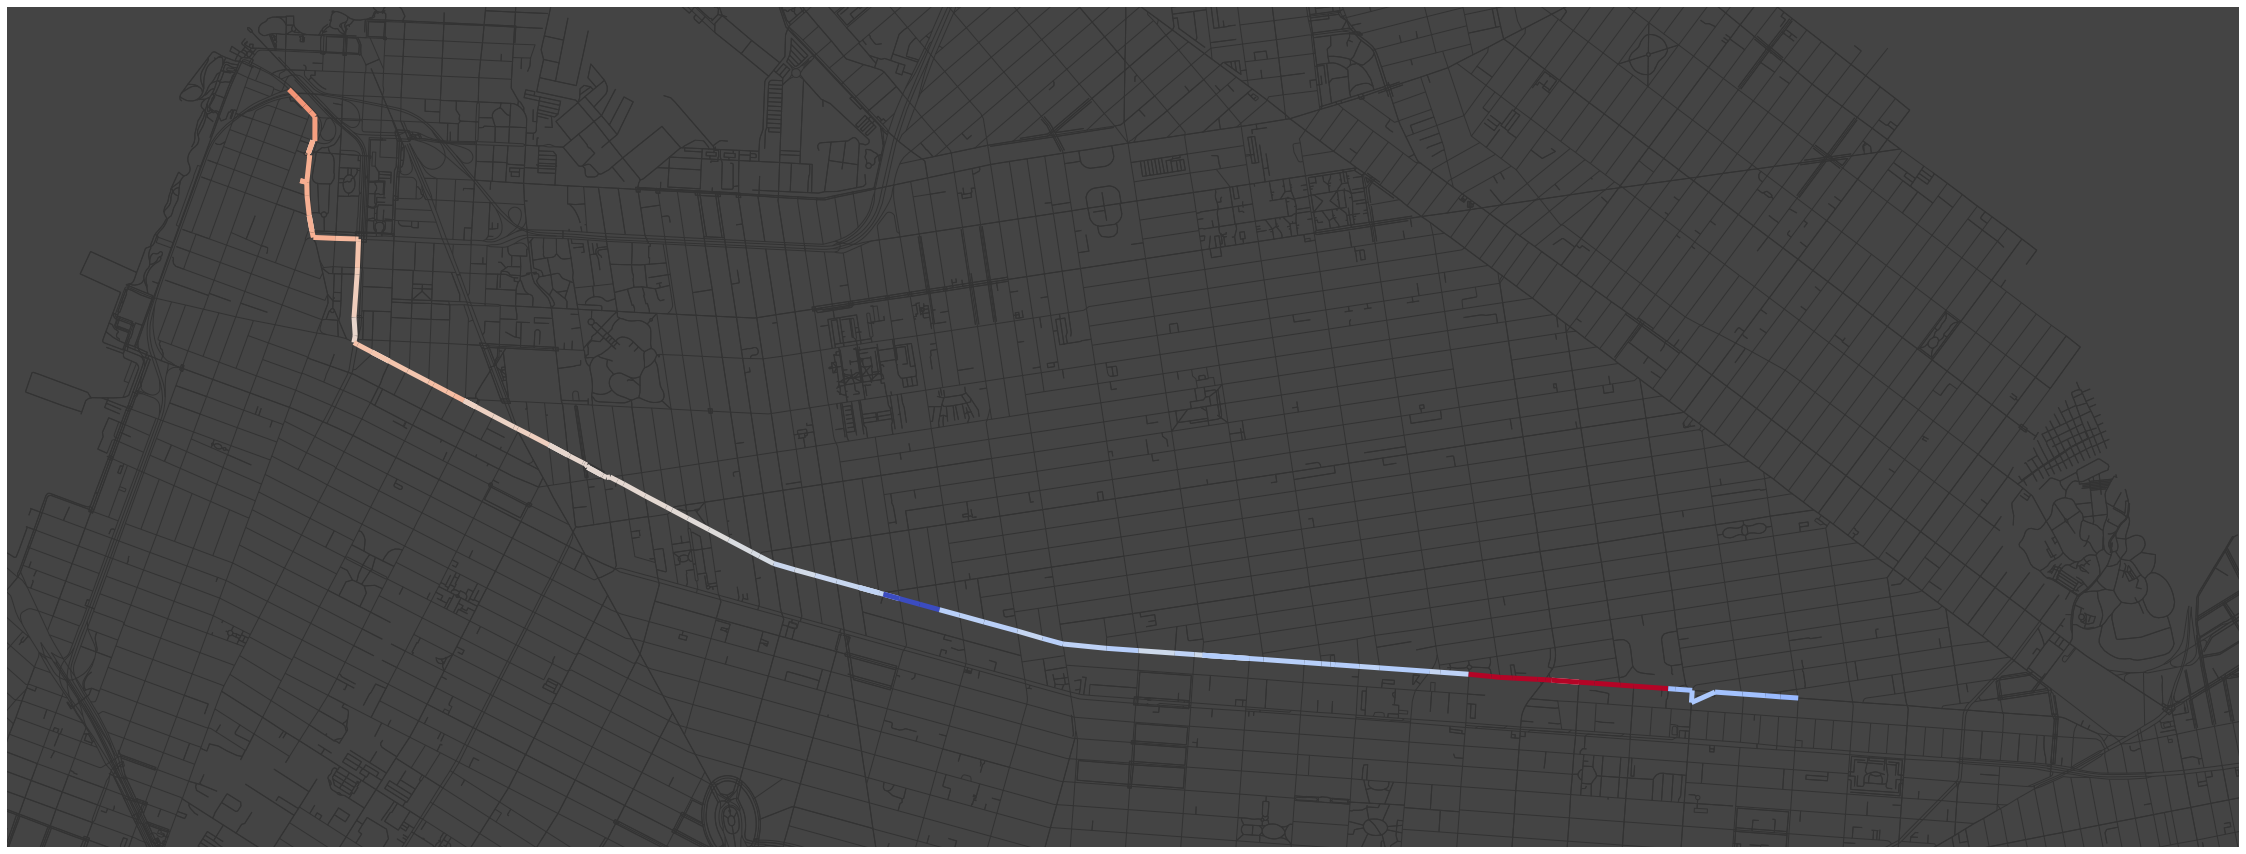

In [326]:
fig, ax = plt.subplots(figsize=(40, 30))
ox.plot_graph(bk, ax=ax, bgcolor='#444', node_size=0, bbox=(40.70501, 40.67289, -73.89407, -74.00660), show=False, close=False, edge_color='#333')

edge_colors = ox.plot.get_edge_colors_by_attr(route_subgraph, attr='weight', cmap='coolwarm')
ox.plot_graph(route_subgraph, ax=ax, bgcolor='#444', node_size=0, bbox=(40.70501, 40.67289, -73.89407, -74.00660), show=False, close=False, edge_color=edge_colors, edge_linewidth=5)
ax.set_facecolor('#444')
plt.show()